# `CLEMnet` predictions on RL012
---
#### Overview
* Model for typical results figure and whatnot

In [38]:
# device = cuda.get_current_device()
# device.reset()

In [39]:
import clemnet

In [40]:
from pathlib import Path
import random
from datetime import datetime
from numba import cuda 

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from skimage import io, exposure, color
from skimage import img_as_ubyte, img_as_float
from skimage.util import invert, crop
from skimage.transform import resize
from sklearn import preprocessing

from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
from PIL import Image, ImageEnhance, ImageOps, ImageFilter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [41]:
# Set GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

# Set colormap
plt.set_cmap('magma')
plt.close();

# Ignore annoying Futurewarning from `gray2rgba`
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Set ... AUTOTUNE?
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Indirectly enable autocomplete
%config Completer.use_jedi = False

In [42]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Create model
Need better resolution for insulin prediction

In [43]:
def get_model(input_shape=(1024, 1024), crop_=False, crop_width=None):
    """U-net-like convolutional neural network
    Parameters
    ----------
    input_shape : tuple
        Shape of input image data
    crop : bool
        Whether to include a cropping layer
    crop_width : int
        Number of pixels to crop from each border

    Returns
    -------
    model : `keras.Model`
        The model (duh)

    References
    ----------
    [1] U-Net: Convolutional Networks for Biomedical Image Segmentation
        https://arxiv.org/abs/1505.04597
    [2] Adapted from
        https://github.com/zhixuhao/unet/blob/master/model.py
    """
    # Create input layer
    input_shape = (*input_shape, 1) if len(input_shape) < 3 else input_shape
    inputs = layers.Input(shape=input_shape)

    # Set up keyword arguments for convolutional layers
    kwargs = {
        'activation': 'relu',
        'padding': 'same',
        'kernel_initializer': 'he_normal'
    }

    # Downsampling arm
    # ----------------
    # Block 1
    conv1 = layers.Conv2D(32, 3, **kwargs)(inputs)
    pool1 = layers.MaxPooling2D(2)(conv1)
    # Block 2
    conv2 = layers.Conv2D(64, 3, **kwargs)(pool1)
    pool2 = layers.MaxPooling2D(2)(conv2)
    # Block 3
    conv3 = layers.Conv2D(128, 3, **kwargs)(pool2)
    pool3 = layers.MaxPooling2D(2)(conv3)
    # Block 4
    conv4 = layers.Conv2D(256, 3, **kwargs)(pool3)
    pool4 = layers.MaxPooling2D(2)(conv4)
    # Block 5
    conv5 = layers.Conv2D(512, 3, **kwargs)(pool4)
    pool5 = layers.MaxPooling2D(2)(conv5)
    # Block 6
    conv6 = layers.Conv2D(1024, 3, **kwargs)(pool5)
    pool6 = layers.MaxPooling2D(2)(conv6)

    # Upsampling arm
    # --------------
    # Block 7
    conv7 = layers.Conv2D(1024, 3, **kwargs)(pool6)
    uppp7 = layers.UpSampling2D(2)(conv7)
    # Block 8
    merg8 = layers.concatenate([conv6, uppp7], axis=3)
    conv8 = layers.Conv2D(1024, 3, **kwargs)(merg8)
    uppp8 = layers.UpSampling2D(2)(conv8)
    # Block 9
    merg9 = layers.concatenate([conv5, uppp8], axis=3)
    conv9 = layers.Conv2D(512, 3, **kwargs)(merg9)
    uppp9 = layers.UpSampling2D(2)(conv9)
    # Block 10
    merg10 = layers.concatenate([conv4, uppp9], axis=3)
    conv10 = layers.Conv2D(256, 3, **kwargs)(merg10)
    conv10 = layers.Conv2D(2, 3, **kwargs)(conv10)

    # Additional upsampling
    uppp11 = layers.UpSampling2D(2)(conv10)

    # Output layer
    conv11 = layers.Conv2D(1, 1, activation='sigmoid')(uppp11)
    model = keras.Model(inputs=inputs, outputs=conv11)
    return model

In [44]:
shape_src = [1024, 1024]
# Set training parameters
repeat = True
n_repetitions = 4
shape_src = [1024, 1024]
shape_tgt = [256, 256]
augment = True
AUGMENTATIONS = {
    'flip': 1,
    'rotate': 1,
    'crop': 0.,
    'elastic': 0.3,
    'invert': 0.,
    'contrast': 0.3,
    'brightness': 0.3,
    'noise': 0.,
}
pad = False
padding = tf.constant([[16, 16],
                       [16, 16],
                       [ 0,  0]])
batch_size = 16
n_cores = 4
input_shape = (1024, 1024)

# Get model
crop_ = pad
crop_width = 16
model = get_model(input_shape=input_shape,
                  crop_=crop_, crop_width=crop_width)
# model.summary()
print('model OK')

model OK


# Preview
---

In [45]:
xy_maxmin = pd.DataFrame()

##### Choose dataset & zoom_level

In [46]:
# 20200618_RL012
# --------------
fp_src = '/home/rlane/FMML_DATA/20210224_FAST-EM_prototype' #change z-selection from == to !=
# fp_src = '/home/rlane/FMML_DATA/20211206_RP_OTO/lil_EM_montaged' #change z-selection from != to ==
# fp_src = '/home/rlane/FMML_DATA/20200618_RL012/2us/hoechst_correlated/'
fm_only = False
z_section = 1



fps_src_FASTEM = list(Path(fp_src).glob('*/*_*_*.png'))
# fps_src_FASTEM_mask = list(Path('/home/mabels/CLEMnet/data/FASTEM/masks').glob('*/*_*_*.png'))
# fps_src_FASTEM = list(Path('/home/mabels/CLEMnet/data/FASTEM/masks').glob('*/*_*_*.png'))

zoom_level_init = 0
zoom_level_to = 0

In [77]:
# Get DataFrame for predicting
df_tst = clemnet.get_DataFrame(fps_src_FASTEM)

# xy_maxmin for all #i zoom_levels
for i in df_tst['zoom'].unique():
    df_tst = clemnet.get_DataFrame(fps_src_FASTEM)
    df_tst = df_tst.loc[df_tst['zoom'] == i]  
    xy_maxmin[i] = [(df_tst['x'].unique().min() if df_tst['x'].unique().min() != 0 else 1), 
                    df_tst['x'].unique().max(), 
                    (df_tst['y'].unique().min() if df_tst['y'].unique().min() != 0 else 1), 
                    df_tst['y'].unique().max()]

# Get DataFrame for predicting
df_tst = clemnet.get_DataFrame(fps_src_FASTEM)
# df_tst_mask = clemnet.get_DataFrame(fps_src_FASTEM_mask)

df_tst = df_tst.loc[df_tst['zoom'] == zoom_level_init]
# df_tst_mask = df_tst_mask.loc[df_tst_mask['zoom'] == zoom_level_init]
# Filter out a test section
df_tst = df_tst.loc[(df_tst['z'] != z_section)]
# df_tst_mask = df_tst_mask.loc[(df_tst_mask['z'] != 1)]

# Filter out outermost rows and columns
# where data is poor or does not exist
b = 0
df_tst_filtered = pd.DataFrame()
df_tst_filtered_mask = pd.DataFrame()

# # Must be done per section, first x, than y
fltr  = pd.DataFrame()

# [[[x0, x1], [y0, y1]]]
fltr_manual = [[[0, xy_maxmin[zoom_level_init][1]], 
                [0, xy_maxmin[zoom_level_init][3]]]]

# FASTEM
# -----------------------------------------------------------------
# Langerhans Island
# -----------------------------------
# fltr_manual = [[[0, 1], [2, 3]]]                # zoom_level = 3
# fltr_manual = [[[2, 6], [9, 12]]]               # zoom_level = 1
# fltr_manual = [[[3, 15], [17, 28]]]             # zoom_level = 0
# fltr_manual = [[[4, 14], [18, 25]]]             # zoom_level = 0
# fltr_manual = [[[7, 8], [24, 25]]]             # zoom_level = 0

# Nucleus in Langerhans Island
# -----------------------------------
# fltr_manual = [[[10 , 10], [27, 27]]]            # zoom_level = 0
# fltr_manual = [[[12 , 14], [18, 20]]]            # zoom_level = 0
# fltr_manual = [[[5, 6], [13, 14]]]              # zoom_level = 1

# Overig
# fltr_manual = [[[8, 10], [8, 10]]]
fltr_manual = [[[10, 11], [27, 28]]]             # zoom_level = 0
# fltr_manual = [[[5, 13], [17, 20]]]             # zoom_level = 0
# -----------------------------------------------------------------


# OSTEM-1
# -----------------------------------------------------------------
# Langerhans Island
# -----------------------------------
# fltr_manual = [[[12, 21], [10, 18]]]                # zoom_level = 0
# fltr_manual = [[[3, 5], [2, 3]]]                # zoom_level = 2
# fltr_manual = [[[8, 11], [4, 7]]]                # zoom_level = 1
# fltr_manual = [[[16, 23], [8, 15]]]                # zoom_level = 0

# Nucleus in Langerhans Island
# -----------------------------------
# fltr_manual = [[[16 , 16], [11, 11]]]            # zoom_level = 0
# fltr_manual = [[[16, 20], [10, 15]]]                # zoom_level = 0



# RL012
# -----------------------------------------------------------------
# Langerhans Island
# -----------------------------------
# fltr_manual = [[[22, 23], [23, 23]]]                # zoom_level = 0

# Nucleus in Langerhans Island
# -----------------------------------


# Overig
# -----------------------------------------------------------------


for i, (z, grp) in enumerate(df_tst.groupby('z')):

    r = 2 # num of decimals     
#     [ xymaxmin[zoom_level = 0]
#       xymaxmin[zoom_level = 1]
#       xymaxmin[zoom_level = 2]
#       xymaxmin[zoom_level = 3]]

    if zoom_level_init <= 3:
#         fltr[str(z)] = [[   [round(((fltr_manual[i][0][0])/(xy_maxmin[zoom_level_init][1]))*xy_maxmin[0][1], r), round((fltr_manual[i][0][1])/(xy_maxmin[zoom_level_init][1])*xy_maxmin[0][1], r)],         [round(((fltr_manual[i][1][0])/(xy_maxmin[zoom_level_init][3])*xy_maxmin[0][3]), r), round(((fltr_manual[i][1][1])/(xy_maxmin[zoom_level_init][3]))*xy_maxmin[0][3], r)]  ],
#                         [   [round(((fltr_manual[i][0][0])/(xy_maxmin[zoom_level_init][1]))*xy_maxmin[1][1], r), round((fltr_manual[i][0][1])/(xy_maxmin[zoom_level_init][1])*xy_maxmin[1][1], r)],         [round(((fltr_manual[i][1][0])/(xy_maxmin[zoom_level_init][3])*xy_maxmin[1][3]), r), round(((fltr_manual[i][1][1])/(xy_maxmin[zoom_level_init][3]))*xy_maxmin[1][3], r)]  ],
#                         [   [round(((fltr_manual[i][0][0])/(xy_maxmin[zoom_level_init][1]))*xy_maxmin[2][1], r), round((fltr_manual[i][0][1])/(xy_maxmin[zoom_level_init][1])*xy_maxmin[2][1], r)],         [round(((fltr_manual[i][1][0])/(xy_maxmin[zoom_level_init][3])*xy_maxmin[2][3]), r), round(((fltr_manual[i][1][1])/(xy_maxmin[zoom_level_init][3]))*xy_maxmin[2][3], r)]  ],
#                             fltr_manual[i]]
        fltr[str(z)] = fltr_manual
#         print(fltr[str(z)][zoom_level_init])
#         print('from zoomlevel', zoom_level_init,'with x0, x1, y0, y1', fltr_manual, 'to zoomlevel:', zoom_level_to, fltr[str(z)][zoom_level_to])

        df_tst_filtered = df_tst_filtered.append(grp.loc[(grp['x'] >= grp['x'].min()+b) &\
                                               (grp['y'] >= grp['y'].min()+b) &\
                                               (grp['x'] <= grp['x'].max()-b) &\
                                               (grp['y'] <= grp['y'].max()-b) &\
                                               (grp['x'] >= fltr[str(z)][zoom_level_init][0][0]) &\
                                               (grp['x'] <= fltr[str(z)][zoom_level_init][0][1]) &\
                                               (grp['y'] >= fltr[str(z)][zoom_level_init][1][0]) &\
                                               (grp['y'] <= fltr[str(z)][zoom_level_init][1][1])])
    else:
        fltr_manual = [[0, xy_maxmin[zoom_level_init][1]], 
        [0, xy_maxmin[zoom_level_init][3]]]
        r = 2 # num of decimals       
        df_tst_filtered = df_tst_filtered.append(grp.loc[(grp['x'] >= grp['x'].min()+b) &\
                                                   (grp['y'] >= grp['y'].min()+b) &\
                                                   (grp['x'] <= grp['x'].max()-b) &\
                                                   (grp['y'] <= grp['y'].max()-b) &\
                                                   (grp['x'] >= fltr_manual[0][0]) &\
                                                   (grp['x'] <= fltr_manual[0][1]) &\
                                                   (grp['y'] >= fltr_manual[1][0]) &\
                                                   (grp['y'] <= fltr_manual[1][1])])


print()
# df_tst_filtered = df_tst
print(df_tst_filtered)
# print(df_tst_filtered_mask)
pd.set_option('display.max_colwidth', -1)
fltr_manual_original_mask_size = [[16, 23], [8, 15]]               # zoom_level = 0


                                                              source  z   y  \
1827  /home/rlane/FMML_DATA/20210224_FAST-EM_prototype/0/27_10_0.png  0  27   
1829  /home/rlane/FMML_DATA/20210224_FAST-EM_prototype/0/27_11_0.png  0  27   
1916  /home/rlane/FMML_DATA/20210224_FAST-EM_prototype/0/28_10_0.png  0  28   
1918  /home/rlane/FMML_DATA/20210224_FAST-EM_prototype/0/28_11_0.png  0  28   

       x  zoom  
1827  10  0     
1829  11  0     
1916  10  0     
1918  11  0     


### Dataset preview

  0%|          | 0/4 [00:00<?, ?it/s]

min: 0.0 max: 1.0


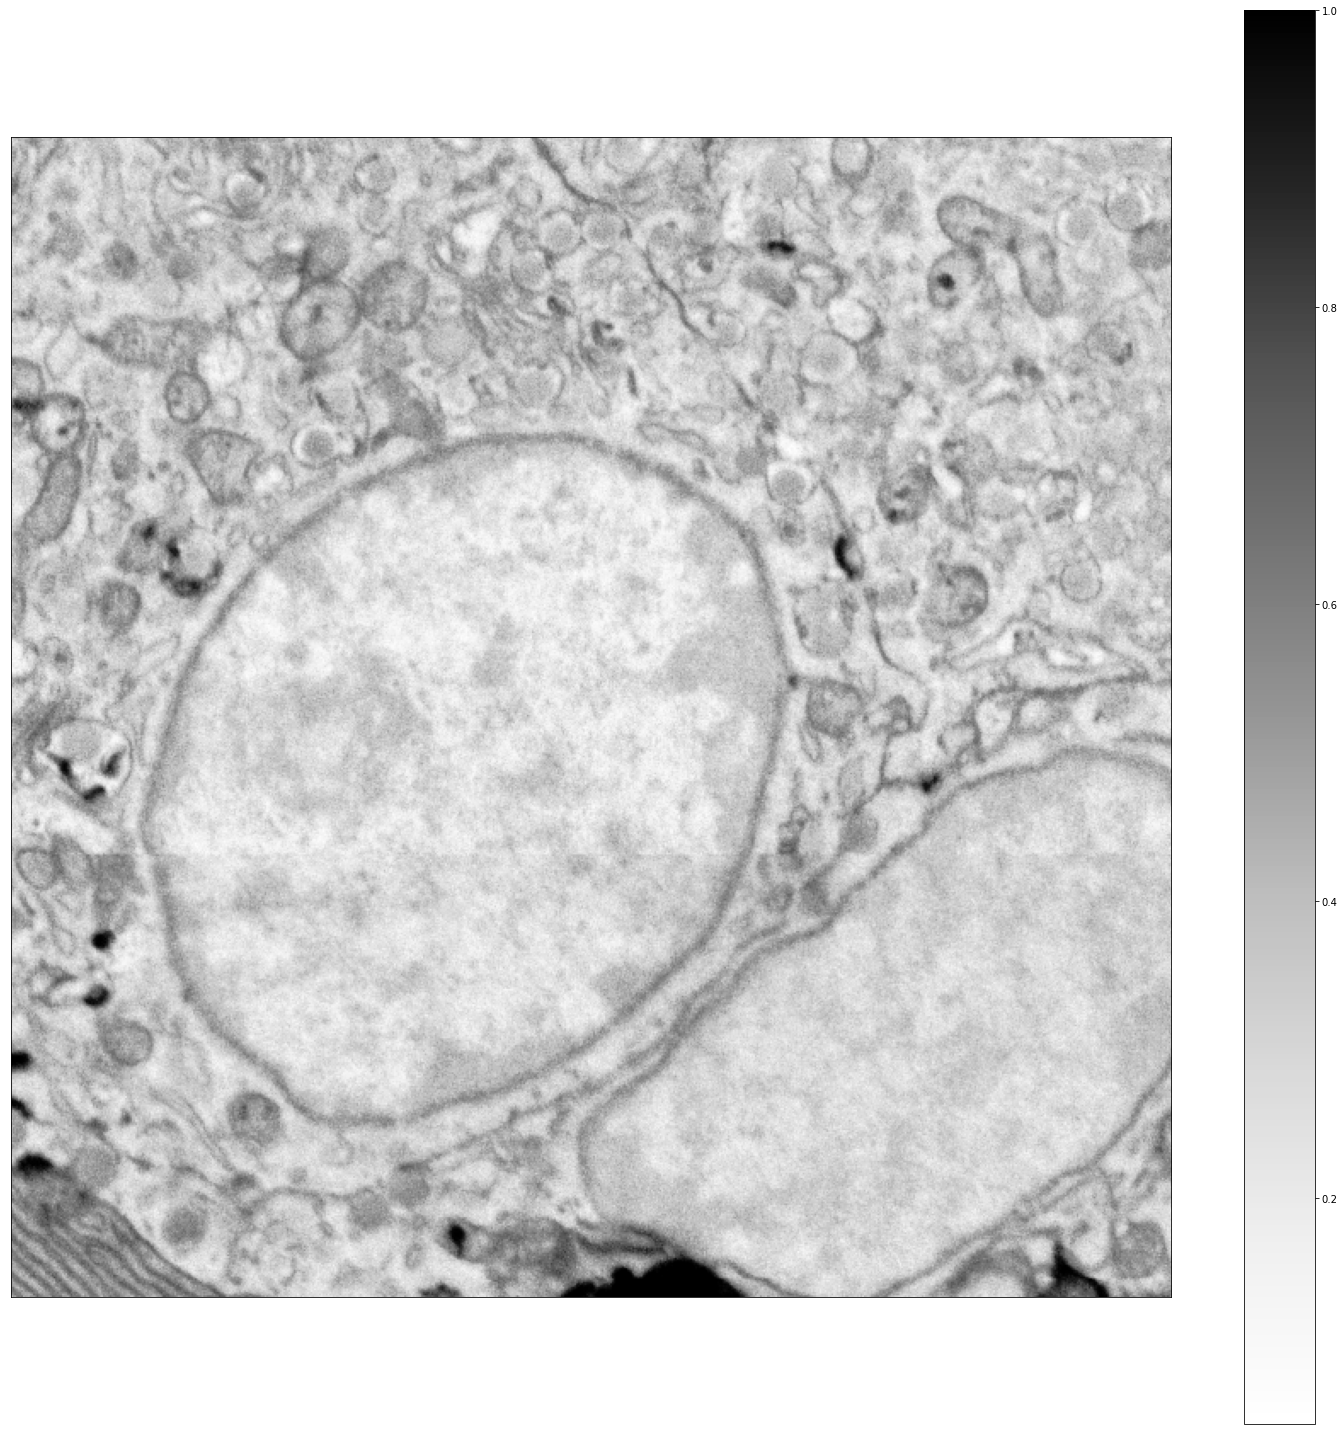

In [78]:
# Make figure
%matplotlib inline
ncols = df_tst_filtered['z'].unique().size
fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(26*ncols, 26),
                         sharex=True, sharey=True, squeeze=False)
axmap = {k:v for k,v in zip(df_tst['z'].unique(), axes.T)}

for z, df_sec in df_tst_filtered.groupby('z'):
    
    # Create dataset for section
    fps_tst_src = df_sec['source']
    ds_section = clemnet.create_dataset(fps_tst_src, shuffle=False, buffer_size=None,
                                        repeat=False, shape_src=shape_src, shape_tgt=shape_tgt,
                                        augment=True, augmentations={'invert': True},
                                        pad=pad, padding=padding, batch=True, batch_size=1,
                                        prefetch=True, n_cores=n_cores)
    len_ds = tf.data.experimental.cardinality(ds_section).numpy()
    
    # Create empty arrays for full section images
    batch_EM = next(iter(ds_section))   
    shape = ((df_sec['y'].max()-df_sec['y'].min() + 1) * batch_EM.shape[1],
             (df_sec['x'].max()-df_sec['x'].min() + 1) * batch_EM.shape[2])
    section_EM = np.empty(shape)

    # Loop through individual EM 
    for (i, row), (batch_EM) in tqdm(zip(df_sec.iterrows(), ds_section), total=len_ds):
         
        # Get indices to populate section images
        x1 = (df_sec.loc[i, 'x'] - df_sec['x'].min()) * shape_src[1]
        y1 = (df_sec.loc[i, 'y'] - df_sec['y'].min()) * shape_src[0]
        x2 = (df_sec.loc[i, 'x'] - df_sec['x'].min() + 1) * shape_src[1]
        y2 = (df_sec.loc[i, 'y'] - df_sec['y'].min() + 1) * shape_src[0]
        

        # Populate section images
#         crop_width = ((0, 0), (0, 0))
#         section_EM[y1:y2, x1:x2] = crop(batch_EM[0,:,:,0], crop_width=crop_width, copy=True)
        section_EM[y1:y2, x1:x2] = batch_EM[0,:,:,0]
#         section_mask[y1:y2, x1:x2] = np.ones(img_OSTEM.shape)
#         section_EM[y1:y2, x1:x2] = (section_EM[y1:y2, x1:x2])*overlay*mask_total[y1:y2, x1:x2] +(1-mask_total[y1:y2, x1:x2])*section_EM[y1:y2, x1:x2]
#         section_EM[y1:y2, x1:x2] = mask_total[y1:y2, x1:x2]
        
#     # Colorize and overlay section images & Plot
#     section_EM = color.gray2rgba(invert(section_EM), alpha=True)
    print('min:', section_EM.min(), 'max:', section_EM.max())
#     section_EM = np.clip(section_EM, 0, 1)
#     print(section_EM.min(), section_EM.max())

    output_shape = [d//3 for d in section_EM.shape[:2]]
    im = axmap[z][0].imshow(resize(section_EM, output_shape), cmap='Greys')
    im.axes.xaxis.set_ticks([])
    im.axes.yaxis.set_ticks([])
    plt.colorbar(im)
#     axmap[z][1].imshow(resize(section_EM, output_shape), cmap='Greys')

# Prediction
---

### Normalizations and Adjustments

In [79]:
def mean_std_adjustments(m0, s0, m1, s1, image):
    std_factor = s1/s0
    mean_adjustment = m1-m0
    image = image+mean_adjustment
    image = tf.image.adjust_contrast(image[:,:,np.newaxis], std_factor)
    image = image.numpy()[:,:,0]
    return image

In [111]:
# Adjustments Training Dataset (preview!)
adjust_blur_tds = True

have_mask = False
plot_original_EM = False
active_mask = '' 
scale = 128

# RL012 and FASTEM mu & sigma
std_RL012 = 0.287
mean_RL012 = 0.462

std_FASTEM = 0.134
mean_FASTEM = 0.487

std_OSTEM_1 = 0.134 #0.127
mean_OSTEM_1 = 0.644 #0.346

# # MB-SEM-OSTEM
# adjust_sharpness_level = 4.5
# adjust_contrast_level = 1.2
# threshold_mask = True
# threshold_val = 0.0375
# # threshold_val = 0.0375
# weights_fn = 'RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_3_20211221_211240.h5' 


# # FASTEM
# adjust_sharpness_level = 5.25 #6.75
# adjust_contrast_level = 0.375 #0.750
# threshold_mask = True
# threshold_val = 0.09 #0.056
# weights_fn = 'RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_0_20211118_003159.h5'
# std_OSTEM = std_FASTEM
# mean_OSTEM = mean_FASTEM

# FASTEM-0 blurred
adjust_sharpness_level = 6.00 #6.75
adjust_contrast_level = 0.375 #0.750
threshold_mask = True
# threshold_val = 0.09 #0.056
threshold_val = 0.49 #0.056
weights_fn = 'RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_3_20211221_211240.h5'
# weights_fn = 'RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_4_20211124_103409.h5'
std_OSTEM = std_FASTEM
mean_OSTEM = mean_FASTEM

# # OSTEM-1
# adjust_sharpness_level = 6.0 #2.25
# adjust_contrast_level = 0.75 #0.375
# threshold_mask = True
# threshold_val = 0.09
# weights_fn = 'RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_0_20211118_003159.h5'
# std_OSTEM = std_OSTEM_1
# mean_OSTEM = mean_OSTEM_1

# # OSTEM-1 - blurred
# adjust_sharpness_level = 0.75 #2.25
# adjust_contrast_level = 1.875 #0.375
# threshold_mask = True
# threshold_val = 0.09
# weights_fn = 'RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_4_20211124_103409.h5'
# std_OSTEM = std_OSTEM_1
# mean_OSTEM = mean_OSTEM_1



mean_3 = 0
sigma_3 = 1

# Adustments Predic Dataset
# everything = 0
everything = 1
# everything = ''

if everything==0:
    adjust_PIL = False
    adjust_invert = False
    adjust_sharpness = False
    adjust_contrast = False
    adjust_mean_std = False
    adjust_clipping = False
elif everything==1:
    adjust_PIL = True
    adjust_invert = True
    adjust_sharpness = True
    adjust_contrast = True
    adjust_mean_std = True
    adjust_clipping = False
else:
    adjust_PIL = True
    
    adjust_invert = True
    adjust_mean_std = False
    adjust_sharpness = False
    adjust_contrast = False
    
    
    adjust_clipping = False
    
preview_prediction = False

In [112]:
# Select Filepath Prediction Dataset
# --------------------------------------
fps_OSTEM = list(Path('/home/rlane/FMML_DATA/20210224_FAST-EM_prototype').glob('*/*_*_*.png'))
# fps_OSTEM = list(Path('/home/rlane/FMML_DATA/20211206_RP_OTO/lil_EM_montaged').glob('*/*_*_*.png'))
fps_BSE = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/lil_EM_2us_montaged/').glob('*/*_*_*.png'))
fps_BSE_blurred = list(Path('/home/mabels/CLEMnet/data/RL012_adjusted/RL012_blurred_1').glob('*/*_*_*.png'))
fps_FM = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/hoechst_correlated/').glob('*/*_*_*.png'))

df_BSE_FM = clemnet.get_DataFrame(fps_BSE, fps_FM)
fps_BSE = df_BSE_FM.source
fps_FM = df_BSE_FM.target

#521 #628 #1827#1916
fp_OSTEM = fps_OSTEM[1916]
num = 999
fp_BSE = fps_BSE[num]
fp_BSE_blurred = fps_BSE_blurred[num]
fp_FM = fps_FM[num]
# 1023

img_OSTEM = img_as_float(io.imread(fp_OSTEM))
img_BSE = img_as_float(io.imread(fp_BSE))
img_BSE_blurred = img_as_float(io.imread(fp_BSE_blurred))
img_FM = img_as_float(io.imread(fp_FM))


# Image PIL enhancements: Sharpness, Contrast, Resizing
# ------------------------------------------------
if adjust_PIL:
    im = Image.open(fp_OSTEM)
    if adjust_invert:
        im = ImageOps.invert(im)
    im.thumbnail((200,200),Image.ANTIALIAS)
    if adjust_sharpness:
        im = ImageEnhance.Sharpness(im)
        im = im.enhance(adjust_sharpness_level)
    if adjust_contrast:
        im = ImageEnhance.Contrast(im)
        im = im.enhance(adjust_contrast_level)
    # im = ImageEnhance.Brightness(im)
    # im = im.enhance(0.0)
    img_OSTEM = np.asarray(im)/255
    # im = Image.fromarray(np.uint8(im))

# Mean & Std Adjustments + Clipping
# ------------------------------------------------
mean_OSTEM = img_OSTEM.mean()
mean_BSE = img_BSE.mean()
std_OSTEM = img_OSTEM.std()
std_BSE = img_BSE.std()
if adjust_mean_std:
    img_OSTEM = mean_std_adjustments(mean_OSTEM, std_OSTEM, mean_BSE, std_BSE, img_OSTEM)
if adjust_clipping:
    img_OSTEM = np.clip(img_OSTEM, 0, 1)
    
# Blur Adjustments Training Dataset
# ------------------------------------------------    
if adjust_blur_tds:
    im = Image.open(fp_BSE)
    im = im.filter(ImageFilter.GaussianBlur(5))
    img_BSE_blurred = np.asarray(im)/255
    
# fps_OSTEM = list(Path('/home/rlane/FMML_DATA/20211206_RP_OTO/lil_EM_montaged').glob('*/*_*_*.png'))
fps_OSTEM = list(Path(fp_src).glob('*/*_*_*.png'))

### Load Weights and make Prediction


In [113]:
# weights:
    
# RL012_1024x1024_hoechst_zoomlevel_0_20211214_083058.h5
# RL012_1024x1024_hoechst_zoomlevel_0_gaussian_blur_2_20211219_191300.h5
# RL012_1024x1024_hoechst_zoomlevel_0_gaussian_blur_3_20211219_033616.h5
# RL012_1024x1024_hoechst_zoomlevel_0_gaussian_blur_4_20211123_191523.h5
# RL012_1024x1024_hoechst_zoomlevel_0_gaussian_blur_5_20211220_183150.h5
# RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_0_20211118_003159.h5
# RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_1_20220107_151123.h5
# RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_2_20220103_185956.h5
# RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_3_20211221_211240.h5
# RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_4_20211124_103409.h5
# RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_5_20220102_165203.h5
# RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_6_20220109_161845.h5

In [114]:
# Make predictions
img_OSTEM = resize(img_OSTEM, (1024,1024))
img_OSTEM_predic = img_OSTEM[np.newaxis,:,:,np.newaxis]

# # # Load weights
# fp_weights = Path('./weights/RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_0_20211118_003159.h5')
# model.load_weights(fp_weights.as_posix())
# predictions_raw = model.predict(img_OSTEM_predic, verbose=1)

# Load weights_blurred
weights = weights_fn
fp_weights = Path('./weights/'+weights)
model.load_weights(fp_weights.as_posix())
predictions_blurred = model.predict(img_OSTEM_predic, verbose=1)

1/1 [==============================] - 0s 1ms/step


In [115]:
# data = pd.read_csv(r'./quant_analysis.csv')
# df = pd.DataFrame(data)
# df

# Make new excel file
# -------------------
# df = pd.DataFrame()

### Preview predictions

In [116]:
if preview_prediction:
    img_PR = predictions_raw[0, :, :, 0].astype(np.float32)                   # (256, 256)
    img_PR_blurred = predictions_blurred[0, :, :, 0].astype(np.float32)       # (256, 256)
    # # Upsample to fit EM
    img_PR = resize(img_PR, (1024,1024))
    img_PR_blurred = resize(img_PR_blurred, (1024,1024))

    # Create PREM & PREM_blurred images
    img_BSE_ = color.gray2rgba(img_BSE, alpha=True)
    img_BSE_blurred_ = color.gray2rgba(img_BSE_blurred, alpha=True)
    img_OSTEM_ = color.gray2rgba(img_OSTEM, alpha=True)

    img_FM_ = clemnet.colorize(img_FM, clemnet.T_HOECHST)
    img_PR_ = clemnet.colorize(img_PR, clemnet.T_HOECHST)
    img_PR_blurred_ = clemnet.colorize(img_PR_blurred, clemnet.T_HOECHST)

    img_CLEM = exposure.rescale_intensity(img_BSE_+img_FM_, in_range=(0, 1))
    img_CLEM_blurred = exposure.rescale_intensity(img_BSE_blurred_+img_FM_, in_range=(0, 1))
    img_PREM = exposure.rescale_intensity(img_OSTEM_+img_PR_, in_range=(0, 1))
    img_PREM_blurred = exposure.rescale_intensity(img_OSTEM_+img_PR_blurred_, in_range=(0, 1))

    #create hists
    hist_BSE, bins_BSE = exposure.histogram(img_BSE)
    hist_OSTEM, bins_OSTEM = exposure.histogram(img_OSTEM)

    # fig 1. RL012 - raw
    # ------------------------------------------------
    fig, axes = plt.subplots(ncols=4, figsize=(14, 6))
    im1 = axes[0].imshow(img_BSE, cmap='Greys_r')
    im2 = axes[1].imshow(img_OSTEM, cmap='Greys_r')
    im3 = axes[2].imshow(img_BSE_blurred, cmap='Greys_r')
    im4 = axes[3].imshow(img_OSTEM, cmap='Greys_r')
    axes[0].title.set_text(F"BSE-RL012, ZL: {zoom_level_init}, Raw")
    axes[1].title.set_text(F"BSE-RL012, ZL: {zoom_level_init}, CLEM")
    axes[2].title.set_text(F"BSE-RL012, ZL: {zoom_level_init}, Blurred")
    axes[3].title.set_text(F"OSTEM, ZL: {zoom_level_init}, Adjusted")

    for i, ax in enumerate(axes):
        ax.axis('off')
        div = make_axes_locatable(ax)
        cax = div.append_axes('left', size='5%', pad=0.4)
        fig.colorbar([im1, im2, im3, im4][i], cax=cax, orientation='vertical')


    # 2. 
    # ------------------------------------------------    
    fig, axes = plt.subplots(ncols=4, figsize=(14, 6))
    im1 = axes[0].imshow(img_CLEM, cmap='Greys_r')
    im2 = axes[1].imshow(img_PREM, cmap='Greys_r')
    im3 = axes[2].imshow(img_CLEM_blurred, cmap='Greys_r')
    im4 = axes[3].imshow(img_PREM_blurred, cmap='Greys_r')
    axes[0].title.set_text('OSTEM, Adjusted')
    axes[1].title.set_text('OSTEM, PREM (BSE-RL012-Raw)')
    axes[2].title.set_text(F"BSE-RL012, ZL: {zoom_level_init}, Blurred, CLEM")
    axes[3].title.set_text(F"OSTEM, ZL: {zoom_level_init}, PREM (BSE-RL012-Blurred)")

    for i, ax in enumerate(axes):
        ax.axis('off')
        div = make_axes_locatable(ax)
        cax = div.append_axes('left', size='5%', pad=0.4)
        fig.colorbar([im1, im2, im3, im4][i], cax=cax, orientation='vertical')

    print()
    print('BSE Mean:', img_BSE.mean(), 'BSE Std:', img_BSE.std())
    print('OSTEM Mean:', img_OSTEM.mean(), 'OSTEM Std:', img_OSTEM.std())
    print()
    print('Inverted:            ', adjust_invert)
    print('Sharpness:           ', adjust_sharpness)
    print('Contrast:            ', adjust_contrast)
    print('Mean & Std:          ', adjust_mean_std)
    print('Clipping:            ', adjust_clipping)

### Full section prediction


Inverted:             True
Sharpness:            True (level: 6.0 )
Contrast:             True (level: 0.375 )
Mean & Std:           True
Clipping:             False

Threshold:             0.49
Weights:             RL012_1024x1024_hoechst_zoomlevel_1_gaussian_blur_3_20211221_211240.h5


  0%|          | 0/4 [00:00<?, ?it/s]

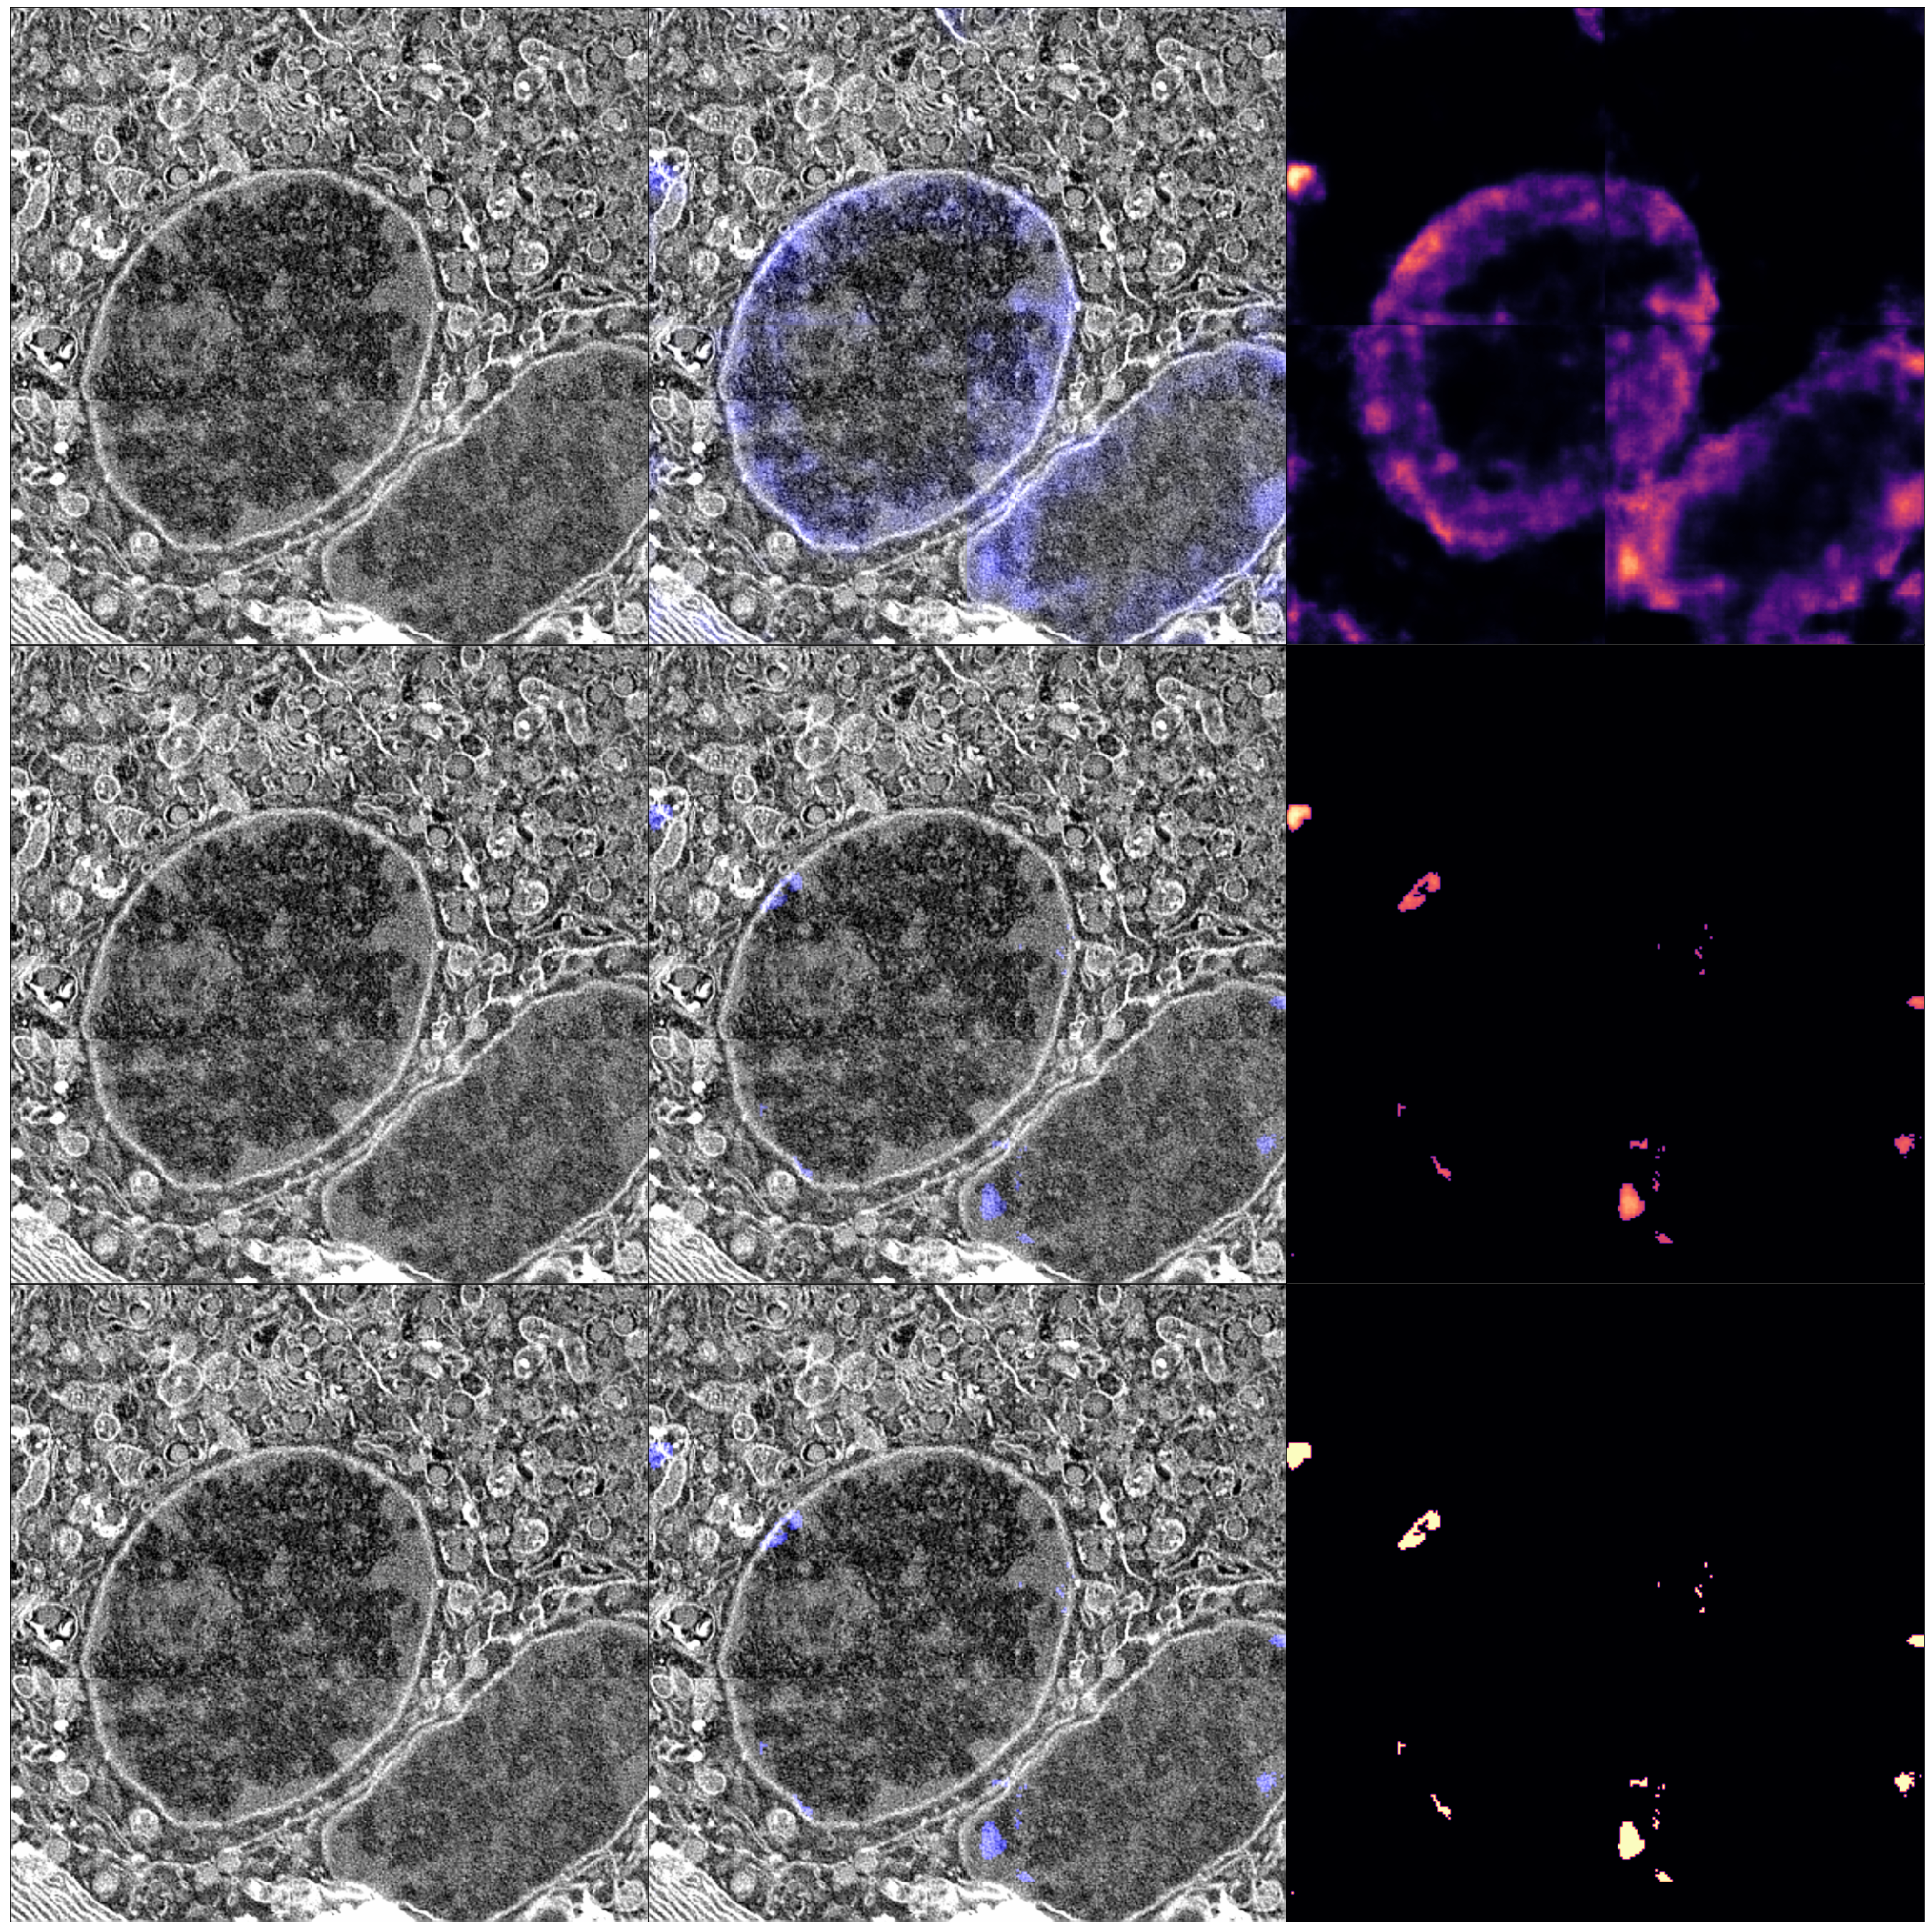

In [117]:
# print('BSE Mean:', img_BSE.mean(), 'BSE Std:', img_BSE.std())
# print('OSTEM Mean:', img_OSTEM.mean(), 'OSTEM Std:', img_OSTEM.std())
print()
print('Inverted:            ', adjust_invert)
print('Sharpness:           ', adjust_sharpness,'(level:',adjust_sharpness_level,')')
print('Contrast:            ', adjust_contrast,'(level:',adjust_contrast_level,')')
print('Mean & Std:          ', adjust_mean_std)
print('Clipping:            ', adjust_clipping)
print()
print('Threshold:            ', threshold_val)
print('Weights:            ', weights_fn)

# Make figure
%matplotlib inline
# ncols = df_tst_filtered['z'].unique().size
# fig, axes = plt.subplots(ncols=ncols, nrows=3, figsize=(6*ncols, 12),
#                          sharex=True, sharey=True, squeeze=False)
# axmap = {k:v for k,v in zip(df_tst_filtered['z'].unique(), axes.T)}

for z, df_sec in df_tst_filtered.groupby('z'):

    # Create dataset for section
    fps_src = df_sec['source']

    ds_section = clemnet.create_dataset(fps_src, shuffle=False, buffer_size=None,
                                        repeat=False, shape_src=shape_src, shape_tgt=shape_tgt, augment=True, augmentations={'invert': adjust_invert},
                                        pad=pad, padding=padding, batch=True, batch_size=1,
                                        prefetch=True, n_cores=n_cores)
    len_ds = tf.data.experimental.cardinality(ds_section).numpy()

    # Create empty arrays for full section images
    batch_EM = next(iter(ds_section))
    shape = ((df_sec['y'].max()-df_sec['y'].min() + 1) * batch_EM.shape[1],
             (df_sec['x'].max()-df_sec['x'].min() + 1) * batch_EM.shape[2])

    section_EM = np.empty(shape)
    section_EM_blurred = np.empty(shape)
    section_PR = np.empty(shape)
    section_mask = np.empty(shape)
    section_PR_thres_1 = np.empty(shape)
    section_PR_thres_2 = np.empty(shape)

    # Loop through individual EM and FM tiles
    for (i, row), (batch_EM) in tqdm(zip(df_sec.iterrows(), ds_section),
                                               total=len_ds):      
        file_name_tile = fps_src[i].rsplit('/', 1)[-1]     
        if active_mask == 'FASTEM-0':
            fps_src_mask = "/home/mabels/CLEMnet/data/FASTEM/masks/"+ str(z) +"/" + file_name_tile
            img_mask = Image.open(fps_src_mask)
            img_mask = np.asarray(img_mask)/255
            img_mask = img_mask[:,:,0]*-1+1

        if active_mask == 'OSTEM-1':
            # ---------------------------------------------------------------
            fps_src_mask = "/home/mabels/CLEMnet/data/OSTEM/masks/0/mask/mask OSTEM.png"
            img_mask = Image.open(fps_src_mask)

            img_mask = np.asarray(img_mask)/255
            y = (row['y']-fltr_manual_original_mask_size[1][0])*scale
            x = (row['x']-fltr_manual_original_mask_size[0][0])*scale
            w = scale
            h = scale

            img_mask = img_mask[y:y+h, x:x+w, 0]
            img_mask = resize(img_mask, (1024,1024))
            img_mask = img_mask[:,:]*-1+1

            # -------------------------------------        
            img_OSTEM = batch_EM[0,:,:,0].numpy()
            # -------------------------------------

              
        img_OSTEM = batch_EM[0,:,:,0].numpy()
        img_BSE_blurred = img_as_float(io.imread(fps_BSE_blurred[i]))
        
        # Image PIL enhancements: Sharpness, Contrast, Resizing
        # ------------------------------------------------
        if adjust_PIL:
            fp_OSTEM = fps_OSTEM[i]
            im = Image.open(fp_OSTEM)

            if adjust_invert:
                im = ImageOps.invert(im)
            im.thumbnail((200,200),Image.ANTIALIAS)
            if adjust_sharpness:
                im = ImageEnhance.Sharpness(im)
                im = im.enhance(adjust_sharpness_level)
            if adjust_contrast:
                im = ImageEnhance.Contrast(im)
                im = im.enhance(adjust_contrast_level)
            # im = ImageEnhance.Brightness(im)
            # im = im.enhance(0.0)
            img_OSTEM = np.asarray(im)/255
            img_OSTEM = resize(img_OSTEM, (1024,1024))

        # Mean & Std Adjustments + Clipping
        # ------------------------------------------------
        if adjust_mean_std:
            img_OSTEM = mean_std_adjustments(mean_OSTEM, std_OSTEM, mean_RL012, std_RL012, img_OSTEM)
        if adjust_clipping:
            img_OSTEM = np.clip(img_OSTEM, 0, 1)
        
        # Make prediction
        img_OSTEM_predic = img_OSTEM[np.newaxis,:,:,np.newaxis]
        prediction = model.predict(img_OSTEM_predic, verbose=0)

        pred = prediction[0,:,:,0]
        pred_threshold_1 = prediction[0,:,:,0]
        pred_threshold_2 = prediction[0,:,:,0]
        
        
        # Threshold value for mask
        if threshold_mask:
            pred_threshold_1 = np.zeros((256, 256)) + pred*(pred > threshold_val)
            pred_threshold_2 = np.zeros((256, 256)) + (pred > threshold_val)
        
        # Get indices to populate section images
        x1 = (df_sec.loc[i, 'x'] - df_sec['x'].min()) * shape_src[1]
        y1 = (df_sec.loc[i, 'y'] - df_sec['y'].min()) * shape_src[0]
        x2 = (df_sec.loc[i, 'x'] - df_sec['x'].min() + 1) * shape_src[1]
        y2 = (df_sec.loc[i, 'y'] - df_sec['y'].min() + 1) * shape_src[0]
        
        if plot_original_EM:
            img_OSTEM = batch_EM[0,:,:,0].numpy()
        
        # Populate section images
        section_EM[y1:y2, x1:x2] = img_OSTEM
        section_EM_blurred[y1:y2, x1:x2] = img_BSE_blurred
        section_PR[y1:y2, x1:x2] = resize(pred, batch_EM.shape[1:3])
        if have_mask:
            section_mask[y1:y2, x1:x2] = img_mask
            section_mask_overlay = (section_mask)*section_PR
        
        section_PR_thres_1[y1:y2, x1:x2] = resize(pred_threshold_1, batch_EM.shape[1:3])
        if have_mask:
            section_mask_overlay_thres_1 = (section_mask)*section_PR_thres_1
        
        section_PR_thres_2[y1:y2, x1:x2] = resize(pred_threshold_2, batch_EM.shape[1:3])
        if have_mask:
            section_mask_overlay_thres_2 = (section_mask)*section_PR_thres_2
        
    # Colorize and overlay section images
    section_PR_ = clemnet.colorize(section_PR/section_PR.max(), T=clemnet.T_HOECHST)
    section_EM_ = color.gray2rgba(section_EM, alpha=True)
    section_PRED = exposure.rescale_intensity(section_EM_ + section_PR_, in_range=(0, 1))
    section_EM = exposure.rescale_intensity(section_EM_, in_range=(0, 1))
    
    section_PR_thres_1_ = clemnet.colorize(section_PR_thres_1/section_PR_thres_1.max(), T=clemnet.T_HOECHST)
    section_PRED_thres_1 = exposure.rescale_intensity(section_EM_ + section_PR_thres_1_, in_range=(0, 1))
    
    section_PR_thres_2_ = clemnet.colorize(section_PR_thres_2/section_PR_thres_2.max(), T=clemnet.T_HOECHST)
    section_PRED_thres_2 = exposure.rescale_intensity(section_EM_ + section_PR_thres_2_, in_range=(0, 1)) 
    
    # Plot
    output_shape = [d//3 for d in section_EM.shape[:2]]
    if have_mask:
        numcols = 5
    else:
        numcols = 3
    fig, axmap = plt.subplots(nrows = 3, ncols=numcols, figsize=(36, 37))
    im1 = axmap[0, 0].imshow(resize(section_EM, output_shape), cmap='Greys_r')
    im2 = axmap[0, 1].imshow(resize(section_PRED, output_shape))
    im3 = axmap[0, 2].imshow(resize(section_PR, output_shape), cmap='magma')
    if have_mask:
        im4 = axmap[0, 3].imshow(resize(section_mask, output_shape), cmap='Greys')
        im5 = axmap[0, 4].imshow(resize(section_mask_overlay, output_shape), cmap='Greys')
    
    im1 = axmap[1, 0].imshow(resize(section_EM, output_shape), cmap='Greys_r')
    im2 = axmap[1, 1].imshow(resize(section_PRED_thres_1, output_shape))
    im3 = axmap[1, 2].imshow(resize(section_PR_thres_1, output_shape), cmap='magma')
    if have_mask:
        im4 = axmap[1, 3].imshow(resize(section_mask, output_shape), cmap='Greys')
        im5 = axmap[1, 4].imshow(resize(section_mask_overlay_thres_1, output_shape), cmap='Greys')
    
    im1 = axmap[2, 0].imshow(resize(section_EM, output_shape), cmap='Greys_r')
    im2 = axmap[2, 1].imshow(resize(section_PRED_thres_2, output_shape))
    im3 = axmap[2, 2].imshow(resize(section_PR_thres_2, output_shape), cmap='magma')
    if have_mask:
        im4 = axmap[2, 3].imshow(resize(section_mask, output_shape), cmap='Greys')
        im5 = axmap[2, 4].imshow(resize(section_mask_overlay_thres_2, output_shape), cmap='Greys')

#     axmap[0, 0].title.set_text(F"OSTEM, ZL: {zoom_level_init}, Adjusted")
#     axmap[0, 1].title.set_text(F"OSTEM, ZL: {zoom_level_init}, PREM (trained on BSE-RL012-Blurred)")
#     axmap[0, 2].title.set_text(F"OSTEM, ZL: {zoom_level_init}, PREM (trained on BSE-RL012-Blurred)")

    for ax in axmap.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
        
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
# # #     # Save
# # #     fp = Path(f'RL010_S{z:03d}_CLEM.png')
# # #     io.imsave(fp.as_posix(), section_CLEM)
# # #     fp = Path(f'RL010_S{z:03d}_PRED.png')
# # #     io.imsave(fp.as_posix(), section_PRED)

# print(threshold,round(threshold_val/pred.max()*100,0),'%'))

if active_mask != '':
    a4 = sum(sum(section_mask_overlay))
    a3 = sum(sum(section_mask))
    a2 = sum(sum(section_PR))
    alpha_raw = a4/a2
    beta_raw = a4/a3

    b4 = sum(sum(section_mask_overlay_thres_1))
    b3 = sum(sum(section_mask))
    b2 = sum(sum(section_PR_thres_1))
    alpha_thres = b4/b2
    beta_thres = b4/b3

    c4 = sum(sum(section_mask_overlay_thres_2))
    c3 = sum(sum(section_mask))
    c2 = sum(sum(section_PR_thres_2))
    alpha_binary = c4/c2
    beta_binary = c4/c3

    w_alpha = 0.80
    w_beta = 1-w_alpha

    # Fill a dictionary 
    dictionary = {'data': [fp_src],
            'type': ['prediction'],
            'zoom_level': [zoom_level_init],
            'weights': [str(fp_weights).rsplit('/', 1)[-1]],
            'mask': [fps_src_mask],

            'inverted': [adjust_invert],
            'sharpness': [adjust_sharpness],
            'sharpness_level': [adjust_sharpness_level],
            'contrast': [adjust_contrast],
            'contrast_level': [adjust_contrast_level],
            'mean_&_std': [adjust_mean_std],
            'clipping': [adjust_clipping],
            'contrast': [adjust_contrast],
            'threshold': [threshold_val],

            'threshold_predic_alpha': [alpha_thres],
            'threshold_predic_beta': [beta_thres],
            'threshold_binary_predic_alpha': [alpha_binary],
            'threshold_binary_predic_beta': [beta_binary], 
            'product_alpha_beta': (w_alpha*alpha_thres+w_beta*beta_binary), 
           }

# sdf  
# Append the dictionary to DataFrame of Excel file
# df2 = pd.DataFrame(dictionary)
# df = df.append(df2)
# df.to_csv('quant_analysis.csv', index=False)


In [37]:
print('Raw pred      alpha:',alpha_raw,'%')
print('              beta: ',beta_raw,'%')
print()

print('Thres         alpha:',alpha_thres,'%')
print('              beta: ',beta_thres,'%')
print()

print('Thres Binary  alpha:',alpha_binary,'%')
print('              beta: ',beta_binary,'%')

Raw pred      alpha: 0.2723139866111251 %
              beta:  0.553763051695726 %

Thres         alpha: 0.7862720665489327 %
              beta:  0.43611555480304015 %

Thres Binary  alpha: 0.7718067480254411 %
              beta:  0.7206380697520336 %
